In [77]:
#import necessary libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#plt.ioff()

In [78]:
data = pd.read_csv('/Users/irene/Documents/UCD/2019_spring/RTG_presentation/code/parkinsons_updrs.txt')
Output = np.array(data.iloc[:,5:6])
list = [1,2]
list.extend(range(7,data.shape[1]))
Input = np.array(data.iloc[:,list])
print(np.shape(Input))
print(np.shape(Output))

(5875, 17)
(5875, 1)


In [93]:
#normalize each variable both input and output
for i in range(Input.shape[1]):
    Input[:,i] = (Input[:,i] - np.mean(Input[:,i]))/np.std(Input[:,i])

for i in range(Output.shape[1]):
    Output[:,i] = (Output[:,i] - np.mean(Output[:,i]))/np.std(Output[:,i])

#mx = MinMaxScaler((np.min(Output),np.max(Output)))
#Output = mx.fit_transform(Output)

train_Input, test_Input, train_Output, test_Output = train_test_split(Input, \
                                                    Output, test_size=0.2, random_state=42)

train_size, num_inputs = train_Input.shape
test_size, num_outputs = test_Output.shape

1


In [110]:
# Define architecture (4 layer)
# This part only defines the computation.
# It doesn't compute anything, it doesn't hold any values, 
# it just defines the operations that you specified in your code
num_nodes1 = 32
num_nodes2 = 16
num_nodes3 = 16
num_nodes4 = 16

#set up the data that will be specified as placeholders
tf_train_data = tf.placeholder(tf.float32, shape=[None, num_inputs])
tf_train_out = tf.placeholder(tf.float32, shape=[None, num_outputs])

layer_num = 4

#setup the initial values of weights and biases as variables(variables are trainable)
def weights_and_biases(a, b):
    '''
    function that creates weights and biases
    '''
    w = tf.Variable(tf.truncated_normal(shape=[a, b], stddev=tf.sqrt(2.0 / a)))
    b = tf.Variable(tf.zeros([b]))
    return w, b

W1, b1 = weights_and_biases(num_inputs, num_nodes1)
W2, b2 = weights_and_biases(num_nodes1, num_nodes2)
W3, b3 = weights_and_biases(num_nodes2, num_nodes3)
W4, b4 = weights_and_biases(num_nodes3, num_nodes4)
W5, b5 = weights_and_biases(num_nodes4, num_outputs)

#setup the computation procedure for each layer (there are other options such as tf.layers.dense...)
activation1 = tf.nn.leaky_relu(tf.add(tf.matmul(tf_train_data, W1), b1), alpha = 0.1)
#activation1 = tf.layers.dense(tf_train_data, num_nodes1, tf.nn.relu)
#activation1 = tf.layers.dropout( activation1, rate = 0.5 ) 
activation2 = tf.nn.leaky_relu(tf.add(tf.matmul(activation1, W2), b2), alpha = 0.1)
activation3 = tf.nn.leaky_relu(tf.add(tf.matmul(activation2, W3), b3), alpha = 0.1)
activation4 = tf.nn.leaky_relu(tf.add(tf.matmul(activation3, W4), b4), alpha = 0.1)
fitted = tf.nn.relu(tf.matmul(activation3, W5))

#define Loss
#loss = tf.reduce_mean(tf.square(tf.subtract(tf_train_out, fitted))) + lam*tf.reduce_sum(tf.pow(W1,2))
lam = 0.1
l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
weights = tf.trainable_variables()
regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

loss = tf.losses.mean_squared_error(tf_train_out, fitted) +  regularization_penalty
mae = tf.losses.absolute_difference(tf_train_out, fitted)

#define Optimizer
optimizer = tf.train.AdamOptimizer().minimize(loss)
#start_learn_rate1 = 0.0001
#global_step1 = tf.Variable(0)
#learn_rate1 = tf.train.exponential_decay(start_learn_rate1, global_step1, 10000, 0.8, staircase=True)
#optimizer1 = tf.train.AdamOptimizer(learn_rate1).minimize(loss_Lp)

In [111]:
def shuffle_aligned_list(data):
    """Shuffle arrays in a list by shuffling each array identically."""
    num = data[0].shape[0]
    p = np.random.permutation(num)
    return [d[p] for d in data]

def batch_generator(data, batch_size, shuffle=True, test=False):
    if shuffle:
        data = shuffle_aligned_list(data)
    batch_count = 0
    while True:
        if test:
            if batch_count * batch_size >= len(data[0]):
                batch_count = 0
                if shuffle:
                    data = shuffle_aligned_list(data)
        else:
            if batch_count * batch_size + batch_size >= len(data[0]):
                batch_count = 0
                if shuffle:
                    data = shuffle_aligned_list(data)
        start = batch_count * batch_size
        end = start + batch_size
        batch_count += 1
        yield [d[start:end] for d in data]

In [112]:
#A session allows to execute the model.

sess = tf.Session()
init = tf.global_variables_initializer()#initializer that initializes the variables
sess.run(init)#initialization
print("Starting to train model...")

batch_size = 50
gen_batch = batch_generator([Input, Output], batch_size)

train_losses, test_losses, mean_abs_errs, test_Ys = ([] for i in range(4))

for i in range(20000): #number of iterations
#i = 0
#while testloss_kl>10:
    input_batch, output_batch = next(gen_batch)
    _,train_loss = sess.run([optimizer,loss], feed_dict={tf_train_data: input_batch, \
            tf_train_out: output_batch})
    
    if np.isnan(train_loss):#if something goes wrong, break!
        print('breaking')
        break
    if i % (1000) == 0: #for every 1000 update, compute the test loss
        [test_loss, mean_abs_err] = sess.run([loss, mae], feed_dict = {tf_train_data: test_Input, \
                 tf_train_out: test_Output})
        
        print("step %d, training loss: %g,test loss: %g" % (i, train_loss, test_loss))
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        mean_abs_errs.append(mean_abs_err)

Starting to train model...
step 0, training loss: 53.8218,test loss: 53.598
step 1000, training loss: 1.20353,test loss: 1.17561
step 2000, training loss: 0.972535,test loss: 0.903583
step 3000, training loss: 0.735901,test loss: 0.836117
step 4000, training loss: 0.854921,test loss: 0.811532
step 5000, training loss: 0.818716,test loss: 0.803012
step 6000, training loss: 0.94108,test loss: 0.793397
step 7000, training loss: 0.953835,test loss: 0.788137
step 8000, training loss: 0.916935,test loss: 0.782945
step 9000, training loss: 1.32507,test loss: 0.782228
step 10000, training loss: 0.660299,test loss: 0.777005
step 11000, training loss: 0.774175,test loss: 0.769908
step 12000, training loss: 0.803975,test loss: 0.768617
step 13000, training loss: 0.706853,test loss: 0.765471
step 14000, training loss: 0.848588,test loss: 0.783086
step 15000, training loss: 0.732444,test loss: 0.75782
step 16000, training loss: 1.01065,test loss: 0.757395
step 17000, training loss: 0.846197,test lo

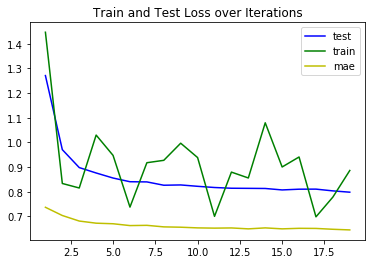

In [109]:
#plot the results
#fig = plt.figure(figsize=(5,5))
plt.plot(range(1,len(test_losses)),test_losses[1:],'b-', label = 'test')
plt.plot(range(1,len(train_losses)),train_losses[1:],'g-', label = 'train')
plt.plot(range(1,len(mean_abs_errs)),mean_abs_errs[1:],'y-', label = 'mae')
plt.title('Train and Test Loss over Iterations')
plt.legend(loc = 'upper right')
figname = '/Users/irene/Documents/UCD/2019_spring/RTG_presentation/code/plot/losses.pdf'
plt.savefig(figname, bbox_inches='tight')
plt.show();
#plt.close(fig)

